# Customer churn

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
path ='/Users/vzuga/Documents/jupyter/'

try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv(path+'/datasets/Churn.csv')

In [3]:
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


The file contains customer data, there are categorical features such as country of residence, gender, activity and availability of a credit card, as well as quantitative features - salary, rating, balance, etc. The target feature is the 'Exited' column - the fact that the client left.

* you need to convert the column names to lowercase
* fill in or remove gaps in 'Tenure' and convert to integer values
* check for duplicates
* columns 'RowNumber', 'CustomerId', 'Surname' are not needed for model training, they can be removed
* check 'Balance', if it is zero for each departed client, then it actually duplicates the target feature and should also be removed
* check unique values ​​in categorical features and outliers in quantitative features

### Column names

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

### Passes

I'll see if the value of 'tenure' is related to something else, like the client's age.

In [5]:
df.dropna().corr()['tenure']

rownumber         -0.007322
customerid        -0.021418
creditscore       -0.000062
age               -0.013134
tenure             1.000000
balance           -0.007911
numofproducts      0.011979
hascrcard          0.027232
isactivemember    -0.032178
estimatedsalary    0.010520
exited            -0.016761
Name: tenure, dtype: float64

No correlation found.

In [6]:
df['tenure'].mean()

4.997690023099769

In [7]:
df['tenure'].median()

5.0

In [8]:
#The mean and median 'tenure' are very close. I will replace all gaps with the median value and convert to int.
#df['tenure'] = df['tenure'].fillna(df['tenure'].median()).astype(int)
#df.isna().sum()

df = df.dropna()

At first I replaced all the gaps with the median value, but I couldn't get the f1-measure to be 0.59, so I decided to remove the gaps and that worked.

### Duplicates

In [9]:
df.duplicated().sum()

0

No obvious duplicates found.

### Deleting columns

In [10]:
df.rownumber.tail(1)

9998    9999
Name: rownumber, dtype: int64

The line number corresponds to the index, I will delete it.

In [11]:
len(df['customerid'].unique())

9091

The number of unique ids is equal to the length of the dataset, which means there are no repetitions. I'll delete it too.

In [12]:
df.query('balance==0').exited.mean()

0.1376789521778861

In [13]:
df.query('balance!=0').exited.mean()

0.24139118457300276

The balance is zero not only for departed customers, this data is necessary for training the model.

In [14]:
df.drop(['rownumber', 'customerid', 'surname'], axis=1, inplace=True)

### Validate values

I'll start with quantitative values.

In [15]:
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


I don't see unusual values. I'll check the categories.

In [16]:
df['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [17]:
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

No abnormal values were found.

### Conclusions

* column names are in lowercase
* gaps in 'tenure' removed
* no obvious duplicates found
* extra data removed
* values checked

## Problem research

### Encoding

In [18]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


For gender and geography, I'll use one-hot encoding.

In [19]:
df = pd.get_dummies(df, drop_first=True)

In [20]:
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Splitting data into samples

I will divide the data into three parts in a ratio of 3:1:1 into training, test and validation samples, respectively.

In [21]:
#features and target extraction
features = df.drop(['exited'], axis=1)
target = df['exited']

In [22]:
#samples
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=.25, random_state=12345)

In [23]:
#sample size check
print(len(features_train), len(features_valid), len(features_test))

5454 1818 1819


### Class balance

I'll look at class balance.

In [24]:
target_train.mean()

0.20517051705170516

In [25]:
target_valid.mean()

0.20132013201320131

In [26]:
target_test.mean()

0.2028587135788895

The classes are not balanced. Clients left in 20% of cases.

### Feature scaling

I standardize numerical features.

In [27]:
#numerical features
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [28]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [29]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
3706,-0.203819,0.471273,0.352316,0.786022,0.782369,0,0,-0.357205,0,1,0
6805,-0.357513,-0.384930,-1.373506,-1.230577,0.782369,1,1,-1.671048,0,0,0
4449,0.175290,-0.289797,-0.683177,-1.230577,0.782369,1,0,-1.119181,0,0,1
598,0.349476,1.708010,0.007151,1.379462,-0.914942,0,0,-1.569064,1,0,0
1845,0.902771,-0.289797,1.387809,-1.230577,-0.914942,0,1,1.543790,0,0,1


### Training the model without imbalance

I will train the models without taking into account the imbalance and see which model has the highest f1-measure.

#### Logistic regression

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_logic = f1_score(target_valid, predicted_valid)
print("F1:", f1_logic)

F1: 0.3004115226337448


#### Decision tree

In [31]:
f1_tree = 0
depth_tree = 0

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    
    if result > f1_tree:
        f1_tree = result
        depth_tree = depth
        
print("F1:", f1_tree)
print('depth:', depth_tree)

F1: 0.557427258805513
depth: 9


#### Random forest

In [32]:
f1_forest = 0
depth_forest = 0
est_forest = 0

for est in range(10, 50, 10):
    for depth in range (1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > f1_forest:
            f1_forest = result
            est_forest = est
            depth_forest = depth_forest
            
print("F1:", f1_forest)
print('Depth:', depth_tree)
print('Number of estimators:', est_forest)

F1: 0.5330948121645795
Depth: 9
Number of estimators: 40


In [33]:
f1_value = pd.DataFrame(data={'model':['LogisticRegression', 'DecisionTree', 'RandomForest'], 
                            'f1_score':[f1_logic, f1_tree, f1_forest]})
f1_value.style.hide_index()

model,f1_score
LogisticRegression,0.300412
DecisionTree,0.557427
RandomForest,0.533095


Logistic regression yielded the smallest f1-measure.

### Conclusions

* applied OHE coding
* class imbalance detected
* numerical signs have been scaled
* trained models without imbalance
* the largest value of the f1-measure was shown by the random forest and decision tree models

## Struggling with imbalance

To improve the models taking into account the imbalance, I will use several methods and see which one will give the best result.

### Class weighting

#### Decision Tree

In [34]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_tree_weight = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_tree_weight = roc_auc_score(target_valid, probabilities_one_valid)

print('F1:', f1_tree_weight)
print('AUC-ROC:', auc_roc_tree_weight)

F1: 0.5387205387205386
AUC-ROC: 0.774092452091707


#### Random forest

In [35]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=9, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_forest_weight = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_forest_weight = roc_auc_score(target_valid, probabilities_one_valid)

print('F1:', f1_forest_weight)
print('AUC-ROC:', auc_roc_forest_weight)

F1: 0.5957446808510637
AUC-ROC: 0.8501351066552257


###  Sample increase

In [36]:
# Upsampling function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#### Decision tree

In [37]:
f1_tree_up = 0
depth_tree = 0

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    
    if result > f1_tree_up:
        f1_tree_up = result
        depth_tree = depth
        
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_tree_up = roc_auc_score(target_valid, probabilities_one_valid)
        
print("F1:", f1_tree_up)
print('Depth:', depth_tree)
print('AUC-ROC:', auc_roc_tree_up)

F1: 0.5555555555555556
Глубина: 7
AUC-ROC: 0.6824965376567462


#### Random forest

In [46]:
f1_forest_up = 0
depth_forest = 0
est_forest = 0

result = 0

for est in range(30, 45):
    for depth in range (5, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > f1_forest_up:
            f1_forest_up = result
            est_forest = est
            depth_forest = depth_forest
            
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_forest_up = roc_auc_score(target_valid, probabilities_one_valid)
            
print("F1:", f1_forest_up)
print('Depth:', depth_tree)
print('Number of estomators:', est_forest)
print('AUC-ROC:', auc_roc_forest_up)

F1: 0.6055488540410132
Depth: 5
Number of estomators: 40
AUC-ROC: 0.8468289451896008


###  Sample reduction

In [39]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#### Decision tree

In [40]:
f1_tree_down = 0
depth_tree = 0

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    
    if result > f1_tree_down:
        f1_tree_down = result
        depth_tree = depth
        
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_tree_down = roc_auc_score(target_valid, probabilities_one_valid)
        
print("F1:", f1_tree_down)
print('Depth:', depth_tree)
print('AUC-ROC:', auc_roc_tree_down)

F1: 0.553191489361702
Глубина: 5
AUC-ROC: 0.6903253849975162


#### Random forest

In [41]:
f1_forest_down = 0
depth_forest = 0
est_forest = 0

result = 0

for est in range(30, 45):
    for depth in range (5, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > f1_forest_down:
            f1_forest_down = result
            est_forest = est
            depth_forest = depth_forest
            
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_forest_down = roc_auc_score(target_valid, probabilities_one_valid)
            
print("F1:", f1_forest_down)
print('Depth:', depth_tree)
print('Number of estimators:', est_forest)
print('AUC-ROC:', auc_roc_forest_down)

F1: 0.5913978494623656
Глубина: 5
Количество деревьев: 30
AUC-ROC: 0.8441550377094341


In [49]:
balance_df = pd.DataFrame(data={
    'model':['DecisionTree', 'DecisionTree', 'DecisionTree', 'RandomForest', 'RandomForest', 'RandomForest'],                               

    'balance':['balanced_weight', 'upsampling', 'downsampling', 'balanced_weight', 'upsampling', 'downsampling'],

    'f1_score':[f1_tree_weight, f1_tree_up, f1_tree_down, f1_forest_weight, f1_forest_up, f1_forest_down],

    'AUC-ROC':[auc_roc_tree_weight, auc_roc_tree_up, auc_roc_tree_down, auc_roc_forest_weight, 
           auc_roc_forest_up, auc_roc_forest_down]})

balance_df.style.hide_index()

model,balance,f1_score,AUC-ROC
DecisionTree,balanced_weight,0.538721,0.774092
DecisionTree,upsampling,0.555556,0.682497
DecisionTree,downsampling,0.553191,0.690325
RandomForest,balanced_weight,0.595745,0.850135
RandomForest,upsampling,0.605549,0.846829
RandomForest,downsampling,0.591398,0.844155


### Conclusions

* random forest model gives the best result
* for the final model I will use the sample increase

## Model testing

In [50]:
model_final = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=9)
model_final.fit(features_upsampled, target_upsampled)
predicted_valid = model_final.predict(features_valid)
print('F1-score on the validation set:',f1_score(target_valid, predicted_valid))

F1-measure on the validation set: 0.6055488540410132


In [51]:
predicted_test = model_final.predict(features_test)

probabilities_test = model_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc_final = roc_auc_score(target_test, probabilities_one_test)


print('F1-score on the test set:',f1_score(target_test, predicted_test))
print('AUC-ROC on the test set:', auc_roc_final)

F1-score on the test set: 0.5948477751756441
AUC-ROC on the test set: 0.8579086066722735


I will plot ROC curve for the final model on a test sample and ROC curve for a random model.

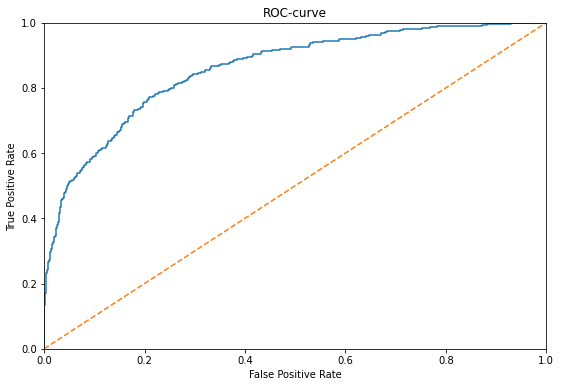

In [52]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(9,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

## Conclusion

* a model of the outflow of bank customers was built
* after studying various models and dealing with imbalances, the class chose a random forest model and increased the sample
*final f1-score was 0.59 and AUC-ROC was 0.85
* model is adequate, AUC-ROC is greater than 0.5 for a random model